# Prediction of river flow using RNN with LSTM architecture

In [1]:
import os
import sys
import textwrap
import time # for measuring time cost

import tensorflow as tf
import numpy as np
import scipy.io as sio # for working with .mat files
import matplotlib.pyplot as plt # for plotting the data and results

from tensorflow.contrib import rnn
from tensorflow.nn import dynamic_rnn
from tensorflow.python.tools import inspect_checkpoint as chkp # import the inspect_checkpoint library
from tensorflow.python.client import device_lib # showing available devices (CPU/GPU)
# import pandas as pd # for working with .xlsx files
from openpyxl import load_workbook # for working with .xlsx files
from datetime import datetime # for keeping separate TB logs for each run
from collections import namedtuple

C:\Users\Martin\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class Params:

    def instance_vars(self):
        return list(self.__dict__.values())

    def format_iter(self, iterable, fmt='{!r}', sep=', '):
        return sep.join(fmt.format(x) for x in iterable)

    def call_repr(self, *args):
        return "{}({})".format(self.__class__.__name__, self.format_iter(args))

    def get_device(self, device='CPU'):
        return [x.name for x in device_lib.list_local_devices() if x.device_type == device]


class HyperParams(Params):
    """Class for defining net hyperparameters"""

    def __init__(self, selected_data=1, n_lstm_layers=2, hidden_size=10, delay=10, pred_step=1, train_batch_size=5,
                 test_batch_size=5, val_batch_size=5, n_epochs=100, stop_epochs=20, check_every=10, init_lr=0.001,
                 n_repeats=1, dropout=False, input_keepProb=1.0, output_keepProb=1.0, recurrent_keepProb=1.0):
        self.input_size = 1  # number of input features (we only follow one variable == flow)
        self.num_classes = 1  # number of output classes (we wan't specific value, not classes, so this is 1)
        self.target_shift = 1  # the target is the same time-series shifted by 1 time-step forward
        self.selected_data = selected_data
        self.n_lstm_layers = n_lstm_layers  # number of vertically stacked LSTM layers
        self.hidden_size = hidden_size  # hidden state vector size in LSTM cell
        self.delay = delay  # the number of time-steps from which we are going to predict the next step
        self.pred_step = pred_step  # the number of time-steps we predict into the future (1 == One-step prediction ; >1 == Multi-step prediction)
        self.train_batch_size = train_batch_size  # number of inputs in one training batch
        self.test_batch_size = test_batch_size  # number of inputs in one testing batch
        self.val_batch_size = val_batch_size  # number of inputs in one validation batch
        self.n_epochs = n_epochs  # number of epochs
        self.stop_epochs = stop_epochs  # if the loss value doesn't improve over the last stop_epochs, the training process will stop
        self.check_every = check_every  # how often to check for loss value in early stopping
        self.init_lr = init_lr  # initial learning rate for Adam optimizer (training algorithm)
        self.n_repeats = n_repeats  # number of repeats of the whole training and validation process with the same params
        # FIGHTING OVERFITTING:
        self.dropout = dropout  # if true the dropout is applied on inputs, outputs and recurrent states of cells
        self.input_keepProb = input_keepProb  # (dropout) probability of keeping the input
        self.output_keepProb = output_keepProb  # (dropout) probability of keeping the output
        self.recurrent_keepProb = recurrent_keepProb  # (dropout) probability of keeping the recurrent state

        self.net_unroll_size = self.delay + self.pred_step - 1  # number of unrolled LSTM time-step cells

    def __repr__(self):
        return self.call_repr(*self.instance_vars()[3:-1])

    # how will the class object be represented in string form (eg. when called with print())
    def __str__(self):
        answer = '''
Input size ...................... {:4d}
Number of classes ............... {:4d}
Target shift .................... {:4d}
Selected data ................... {:4d}
Number of stacked LSTM layers ... {:4d}
Hidden state size ............... {:4d}
Delay ........................... {:4d}
Number of prediciton steps....... {:4d}
Training batch size ............. {:4d}
Testing batch size .............. {:4d}
Validation batch size ........... {:4d}
Maximum number of epochs ........ {:4d}
Early stopping epochs ........... {:4d}
Check (save) every (epochs)...... {:4d}
Initial learning rate ........... {:9.4f}
Number of repeats ............... {:4d}
Dropout ......................... {!s:>7}'''.format(*self.instance_vars()[:-4])

        dropout_answer = '''
Input keep probability .......... {:7.2f}
Output keep probability ......... {:7.2f}
Recurrent keep probability ...... {:7.2f}'''.format(*self.instance_vars()[-4:-1])

        return answer + dropout_answer if self.dropout else answer


class Settings(Params):
    """Class for chosing the behaviour of various program functions"""

    def __init__(self, continue_learning=False, use_gpu=False, save_figures=False):
        self.continue_learning = continue_learning
        self.use_gpu = use_gpu
        self.save_figures = save_figures
        try:
            self.device = self.get_device('GPU')[0] if use_gpu else self.get_device('CPU')[0]
        except IndexError:
            print('There are no available GPUs, switching to CPU')
            self.device = self.get_device('CPU')[0]

    def __repr__(self):
        return self.call_repr(*self.instance_vars()[:-1])

    def __str__(self):
        return '''
Continue learning ............... {}
Use GPU ......................... {}
Save figures .................... {}
Device .......................... {}'''.format(*self.instance_vars())


In [3]:
# NET AND TRAINING HYPERPARAMETERS
par = HyperParams(selected_data=2  # select input data for the network
                , n_lstm_layers=6
                , hidden_size=64
                , delay=48
                , pred_step=7
                , train_batch_size=16
                , test_batch_size=4
                , val_batch_size=4
                , n_epochs=200
                , stop_epochs=20  # if <= 0 then early stopping is disabled and check every sets the saving period
                , check_every=10
                , init_lr=0.001
                , n_repeats=1
                , dropout=True
                , input_keepProb=1.0
                , output_keepProb=0.75
                , recurrent_keepProb=1.0)

# SET PROGRAM FUNCTION SETTINGS
setting = Settings(continue_learning=False,  # continue training the model with saved variables from previeous training
                   use_gpu=False,            # deciding which device (CPU/GPU) should be used for tf operations
                   save_figures=False)       # save resulting figures or not

# decaying learning rate constants (for exponential decay)
# Adam already has adaptive learning rate for individual weights 
# but it can be combined with decaying learning rate for faster convergence
decay_steps = par.n_epochs // 10  # every "n_epochs//10" epochs the learning rate is reduced
decay_rate = 1  # the base of the exponential (rate of the decay ... 1 == no decay)

num_outputs = 1

In [4]:
print(par)
repr(par)


Input size ......................    1
Number of classes ...............    1
Target shift ....................    1
Selected data ...................    2
Number of stacked LSTM layers ...    6
Hidden state size ...............   64
Delay ...........................   48
Number of prediciton steps.......    7
Training batch size .............   16
Testing batch size ..............    4
Validation batch size ...........    4
Maximum number of epochs ........  200
Early stopping epochs ...........   20
Check (save) every (epochs)......   10
Initial learning rate ...........    0.0010
Number of repeats ...............    1
Dropout .........................    True
Input keep probability ..........    1.00
Output keep probability .........    0.75
Recurrent keep probability ......    1.00


'HyperParams(2, 6, 64, 48, 7, 16, 4, 4, 200, 20, 10, 0.001, 1, True, 1.0, 0.75, 1.0)'

## Data selection options
### 1) DATA from prof. A. Procházka:
* **url:**: http://uprt.vscht.cz/prochazka/pedag/Data/dataNN.zip
* **name**: Weekly Elbe river flow
* **Provider source:** Prof. Ing. Aleš Procházka, CSc
* **Span:** 313 weeks ~ 6 years of data
* **Data size:** 313 values
* **Already normalized** to 0 mean and 1 variance

### 2) DATA from Time Series Data Library:
* **url:** https://datamarket.com/data/set/235a/mean-daily-saugeen-river-flows-jan-01-1915-to-dec-31-1979#!ds=235a&display=line
* **name:** Mean daily Saugeen River (Canada) flows
* **Provider source:** Hipel and McLeod (1994)
* **Span:** Jan 01, 1915 to Dec 31, 1979
* **Data size:** 23741 values

In [5]:
def z_score(array, inverse=False, mean=0, std=1):
    """
    Z-Score estimator standardization of the array.
    :param array: numpy array to be standardized
    :param inverse: if True, the inverse operation will be applied
    :param mean: the mean value of the original array before it was standardised (needed for inverse)
    :param std: the standard deviation value of the original array before it was standardised (needed for inverse)
    :return: array of
    """
    if inverse:  # inverse Z-Score
        return (std*array + mean).flatten()
    else:  # Z-Score standardization
        return (np.divide((array - np.mean(array)),np.std(array))).flatten()
    
def tanh_estimator(array, inverse=False, mean=0, std=1):
    """
    Tanh estimator standardization of the array.
    :param array: numpy array to be standardized
    :param inverse: if True, the inverse operation will be applied
    :param mean: the mean value of the original array before it was standardised (needed for inverse)
    :param std: the standard deviation value of the original array before it was standardised (needed for inverse)
    :return: array of
    """
    if inverse:  # inverse tanh_estimator
        return (100 * std * np.arctanh(2 * array - 1) + mean).flatten()  ## CHECK THE RANGE!!!
    else:  # tanh_estimator standardization
        return (0.5 * (np.tanh(0.01 * np.subtract(array, np.mean(array)) / np.std(array)) + 1)).flatten()
    
def shift_array(array, shift=1, fill=0):
    """
    Shift numpy array 'shift' places to the right and fill the emtpy spaces at the beginning with value 'fill'

    :param array: 1D numpy array
    :param shift: integer value defining the number of shifts to the right
    :param fill: value to be inserted in place of the empty values at the beginning of the array
    :return: shifted numpy array
    """
    array = np.roll(array, shift)
    array[:shift] = fill
    return array

def data_choice(selection=1, data_division=(0.75, 0.15)):
    """
    Choose a time series to be processed by the neural network. The function returns
    two normalized (tanh-estimator) series as namedtuple objects with fields:
        train ... the training part of the dataset
        test ... the testing part of the dataset
        val ... the validation part of the dataset
        min ... the lowest value of the dataset before normalization (inputs) and after normalization (targets)
        max ... the highest value of the dataset before normalization (inputs) and after normalization (targets)
        mean ... mean of the dataset before normalization (inputs) and after normalization (targets)
        std ... standard deviation of the dataset before normalization (inputs) and after normalization (targets)

    :param selection: input 1 for the small dataset or 2 for the big dataset
    :param data_division: % of data to be used for (training, testing), validation part is the remainder of the data
    :return: namedtuples 'inputs' and 'targets' with train, test, val, min, max, mean, std fields and plot_range
    """
    Data = namedtuple('Data', ['train', 'test', 'val', 'min', 'max', 'mean', 'std'])

    if selection == 1:
        filename = './datasets/Q.MAT'
        data = sio.loadmat(filename)  # samples were gathered with period of one week
        data = np.array(data['Q'], dtype=np.float32)

        data_in_year = 52.1775  # number of weeks in one year
        years_in_data = np.shape(data)[1] / data_in_year

        plot_range = slice(0, None, 1)

    elif selection == 2:
        # load excel spreadsheet with openpyxl:
        filename = './datasets/sugeen-river-flows.xlsx'
        xl = load_workbook(filename)

        # get sheet by name:
        sheet = xl['Mean daily saugeen River flows,']

        # fill a list with values from cells:
        data = [cell[0].value for cell in sheet['B16:B23756']]

        # convert list to numpy array and reshape to a column vector
        data = np.array(data, dtype=np.float32)
        data = np.reshape(data, (1, -1))

        data_in_year = 365.25  # number of days in one year
        years_in_data = np.shape(data)[1] / data_in_year

        plot_range = slice(int(data_in_year * 2), int(data_in_year * 3), 1)
    else:
        print("Wrong selection. Please select 1 for small dataset or 2 for big dataset.")
        return None
    # get the bounds, mean and std of data before normalization
    inputs_min = np.min(data)
    inputs_max = np.max(data)
    inputs_mean = np.mean(data)  # mean
    inputs_std = np.std(data)    # standard deviation

    # standardize the data using Z-Score
    # data = np.divide(np.subtract(data, inputs_mean), inputs_std).flatten()
    data = z_score(data)

    # divide the data into training, testing and validation part
    years_in_train = int(0.7 * years_in_data)  # 70% of data rounded to the number of years
    years_in_test = int(np.ceil(0.15 * years_in_data))  # 15% of data rounded to the number of years

    len_train = int(years_in_train * data_in_year)  # number of data-points in training data
    len_test = int(years_in_test * data_in_year)  # number of data-points in testing data

    # slices of the training, testing and validation parts of the data
    train_part = slice(0, len_train)
    test_part = slice(len_train, len_train + len_test)
    val_part = slice(len_train + len_test, None)

    # divide the data slices into the namedtuple inputs
    inputs = Data(data[train_part],
                  data[test_part],
                  data[val_part],
                  inputs_min,
                  inputs_max,
                  inputs_mean,
                  inputs_std)

    # create the targets which is the inputs shifted by 1 time-step forward
    targets = Data(shift_array(inputs.train),
                   shift_array(inputs.test),
                   shift_array(inputs.val),
                   np.min(data),
                   np.max(data),
                   np.mean(data),
                   np.std(data))

    # return the data slices, original mean and standard deviation and desired ranges of plots
    return inputs, targets, plot_range

In [6]:
inputs, targets, plot_range = data_choice(par.selected_data)

In [7]:
# reset TensorFlow graph
tf.reset_default_graph()

with tf.device(setting.device):
    # define tensorflow constants
    data_min = tf.constant(inputs.min, dtype=tf.float32, name='data_min')
    data_max = tf.constant(inputs.max, dtype=tf.float32, name='data_max')
    data_mean = tf.constant(inputs.mean, dtype=tf.float32, name='data_mean')
    data_std = tf.constant(inputs.std, dtype=tf.float32, name='data_std')

    # define output weights and biases
    with tf.name_scope("output_layer"):
        weights_out = tf.Variable(tf.random_normal([par.hidden_size,par.num_classes]),name='weights_out')
        bias_out = tf.Variable(tf.random_normal([par.num_classes]),name='biases_out')

    # define placeholders for the batches of time-series
    x = tf.placeholder(tf.float32,[None, par.net_unroll_size, par.input_size],name='x') # batch of inputs
    y = tf.placeholder(tf.float32,[None, par.num_classes, num_outputs],name='y') # batch of labels

    # define placeholders for dropout keep probabilities
    input_kP = tf.placeholder(tf.float32,name='input_kP')
    output_kP = tf.placeholder(tf.float32,name='output_kP')
    recurrent_kP = tf.placeholder(tf.float32,name='recurrent_kP')
    
    # processing the input tensor from [par.batch_size,par.delay,par.input_size] to "par.delay" number of [par.batch_size,par.input_size] tensors
    input=tf.unstack(x, par.net_unroll_size, 1, name='LSTM_input_list') # create list of values by unstacking one dimension
    # input = tf.reshape(x,[-1, par.net_unroll_size, par.input_size])

In [8]:
tf.shape(input)

<tf.Tensor 'Shape:0' shape=(3,) dtype=int32>

In [9]:
# function to create an LSTM cell:
def make_cell(hidden_size):
    return rnn.LSTMCell(hidden_size, state_is_tuple=True, activation=tf.tanh)

# define an LSTM network with 'par.n_lstm_layers' layers
with tf.device(setting.device):
    with tf.name_scope("LSTM_layer"):
        lstm_cells = rnn.MultiRNNCell([make_cell(par.hidden_size) for _ in range(par.n_lstm_layers)], state_is_tuple=True)

        # add dropout to the inputs and outputs of the LSTM cell (reduces overfitting)
        lstm_cells = rnn.DropoutWrapper(lstm_cells, input_keep_prob=input_kP, output_keep_prob=output_kP, state_keep_prob=recurrent_kP)

        # create static RNN from lstm_cell
        outputs,_ = rnn.static_rnn(lstm_cells, input, dtype=tf.float32)
    #    outputs,_ = tf.nn.dynamic_rnn(lstm_cells, x, dtype=tf.float32)

In [10]:
# generate a list of predictions based on the last "par.pred_step" time-step outputs (multi-step prediction)
with tf.device(setting.device):
    prediction = [tf.matmul(outputs[-i-1],weights_out) + bias_out for i in (range(num_outputs))] # future prediction first
    prediction = prediction[::-1] #reverse the list (one-step prediction first)

    prediction = tf.reshape(prediction,[-1,par.num_classes,num_outputs])

In [11]:
with tf.device(setting.device):
    with tf.name_scope("loss"):
    #    regularization_cost = tf.reduce_sum([ tf.nn.l2_loss(v) for v in tv ])
        loss = tf.sqrt(tf.losses.mean_squared_error(predictions=prediction,labels=y)) # RMSE (root mean squared error)

# exponential decay of learning rate with epochs
global_step = tf.Variable(1, trainable=False, name='global_step') # variable that keeps track of the step at which we are in the training
increment_global_step_op = tf.assign(global_step, global_step+1,name='increment_global_step') # operation that increments global step by one

with tf.device(setting.device):
    # decayed_learning_rate = learning_rate * decay_rate ^ (global_step / )
    learning_rate = tf.train.exponential_decay(par.init_lr, global_step,
                                               decay_steps, decay_rate, staircase=True) # decay at discrete intervals

    # define Adam optimizer for training of the network
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [12]:
def inverse_z_score(value):
    return data_std*value + data_mean

def inverse_tanh(value):
    return 100 * data_std * tf.atanh(2 * value - 1) + data_mean

with tf.device(setting.device):
    # denormalize data (from (0,1)):
    # denormalized_prediction = data_min + tf.multiply(prediction, tf.subtract(data_max,data_min))
    # denormalized_y = data_min + tf.multiply(y, tf.subtract(data_max,data_min))

    # denormalize data (from (-1,1)): <- better
#    denormalized_prediction = data_mean + tf.multiply(prediction, data_std)
#   denormalized_y = data_mean + tf.multiply(y, data_std)
    denormalized_prediction = inverse_z_score(prediction)
    denormalized_y = inverse_z_score(y)

    # calculate relative error of denormalized data:
    with tf.name_scope("SMAPE"):
        SMAPE = tf.minimum(2*tf.reduce_mean(tf.divide(tf.abs(
                                                      tf.subtract(denormalized_prediction,denormalized_y))
                                           ,tf.add(tf.abs(denormalized_y),tf.abs(denormalized_prediction)))),2)

In [13]:
# TensorBoard summaries (visualization logs)
# histogram summary for output weights
w_out_summ = tf.summary.histogram("w_out_summary", weights_out)
# scalar summary for loss function
# training_loss_summ = tf.summary.scalar("training_loss",loss)
# testing_loss_summ = tf.summary.scalar("testing_loss",loss)
# scalar summary for relative error
# training_error_summ = tf.summary.scalar("relative_training_error",SMAPE)
# testing_error_summ = tf.summary.scalar("relative_testing_error",SMAPE)

# NOT USEFUL HERE
# merge the summaries of all tf.summary calls (for TensorBoard visualization)
# merged = tf.summary.merge_all()

In [14]:
def create_batch(x_data,y_data,batch_size,index):
    """
    function for generating the time-series batches

    :param x_data: input data series
    :param y_data: output data series
    :param batch_size: size of one batch of data to feed into network
    :param index: index of the current batch of data
    :return: input and output batches of data
    """
    
    x_batch = np.zeros([batch_size,par.delay,par.input_size])
    x_pad = np.zeros([batch_size,par.pred_step-1,par.input_size])
    y_batch = np.zeros([batch_size,par.num_classes,num_outputs])
    
    step = index*batch_size
    
    for i in range(batch_size):
        x_batch[i,:,:] = np.reshape(x_data[step+i:step+i+par.delay],(par.delay,par.num_classes))
        y_batch[i,:] = np.reshape(y_data[step+i+par.delay+par.pred_step],(1,par.num_classes,num_outputs))
    
    # the last "par.pred_step - 1" columns in x_batch are padded with 0
    # because there are no inputs into the net at these time steps
    x_batch = np.hstack((x_batch, x_pad))
    
#    print(x_batch)
#    print('________________')
#    print(y_batch)
#    print('================')
    
    return x_batch, y_batch

In [15]:
def run_model(inputs,labels,batch_size,save=False,train=False):
    """
    feeding the model with batches of inputs, running the optimizer for training and getting training and testing results

    :param inputs: input data series
    :param labels: output data series
    :param batch_size: the size of the data batch
    :param save: if True the predicted time series is returned as a list
    :param train: if True the optimizer will be called to train the net on provided inputs and labels
    :return: loss (cost) and prediction error throughout the whole data set and if save = True: also returns the list of predicted values
    """
    
    prediction_list = [] # list for prediction results
    loss_val_sum = 0 # sum of the loss function throughout the whole data
    error_val_sum = 0 # sum of the relative error function throughout the whole data
    error_val_mean = 0
    prefix = ""
    
    # number of batches == number of iterations to go through the whole dataset once
    n_batches = (len(inputs)-par.delay-par.pred_step)//batch_size
    
    for i in range(n_batches):

        x_batch, y_batch = create_batch(inputs,labels,batch_size,i)
        
        # dropout at training
        if par.dropout:
            feed_dict_train = {x: x_batch, y: y_batch, input_kP: par.input_keepProb, 
                               output_kP: par.output_keepProb, recurrent_kP: par.recurrent_keepProb}
        else:
            feed_dict_train = {x: x_batch, y: y_batch, input_kP: 1.0, output_kP: 1.0, recurrent_kP: 1.0}
            
        # no dropout at testing and validation
        feed_dict_test = {x: x_batch, y: y_batch, input_kP: 1.0, output_kP: 1.0, recurrent_kP: 1.0}
            
        # train the net on the data
        if train:
            prefix = "Training_" # for summary writer
            session.run(optimizer,feed_dict=feed_dict_train) # run the optimization on the current batch
        else:
            prefix = "Testing_" # for summary writer
            
        loss_val, prediction_val, error_val = session.run(
            (loss, denormalized_prediction, SMAPE), feed_dict=feed_dict_test)
        
        # prediction_val is a list of length "num_outputs" with arrays of "batch_size" output values
        # convert to numpy array of shape (batch_size, num_outputs)
        prediction_val = np.array(prediction_val)
        # reshape the array to a vector of shape (1, num_outputs*batch_size)
        prediction_val = np.reshape(prediction_val, (1, num_outputs*batch_size))
        
        loss_val_sum += loss_val # sum the losses across the batches
        error_val_sum += error_val # sum the errors across the batches
            
        # save the results
        if save:
            # save the batch predictions to a list
            prediction_list.extend(prediction_val[0,:])
            
    # the mean value of loss (throughout all the batches) in current epoch 
    loss_val_mean = loss_val_sum/n_batches        
    # the mean of relative errors
    error_val_mean = error_val_sum/n_batches
        
    # Create a new Summary object for sum of losses and mean of errors
    loss_summary = tf.Summary()
    error_summary = tf.Summary()
    loss_summary.value.add(tag="{}Loss".format(prefix), simple_value=loss_val_mean)
    error_summary.value.add(tag="{}Error".format(prefix), simple_value=error_val_mean)

    # Add it to the Tensorboard summary writer
    # Make sure to specify a step parameter to get nice graphs over time
    summary_writer.add_summary(loss_summary, epoch)
    summary_writer.add_summary(error_summary, epoch)

    return loss_val_mean, error_val_mean, prediction_list

In [16]:
def early_stopping(loss_val,epoch,stop_epochs,check_every):
    """
    Save the model coefficients if the data loss function value is better than the last loss function value.

    :param loss_val: current value of loss function
    :param epoch: current epoch
    :param stop_epochs: number of epochs after which the training is stopped if the loss is not improving
    :param check_every: define the period in epochs at which to check the loss value (and at which to save the data)
    :return: the epoch at which the best loss was and the value of the loss (ergo at which the last checkpoint was created)
    """
    
    stop_training = False
    
    # initialize function attributes
    if not hasattr(early_stopping,"best_loss"):
        early_stopping.best_loss = loss_val
        early_stopping.best_epoch = epoch
    
    # saving if the loss val is better than the last
    if stop_epochs > 0 and epoch % check_every == 0:
        # if loss val is better than best_loss save the model parameters
        if loss_val < early_stopping.best_loss:
            saver.save(session, './checkpoints/Multi-Step_LSTMforPredictingLabeFlow') 
            early_stopping.best_loss = loss_val
            early_stopping.best_epoch = epoch
            print("Model saved at epoch {} \nwith testing loss: {}.".format(epoch,loss_val))
        else:
            print("Model NOT saved at epoch {} \nwith testing loss: {}".format(epoch,loss_val))
            
        print("____________________________")
    
        # if the loss didn't improve for the last stop_epochs number of epochs then the training process will stop
        if (epoch - early_stopping.best_epoch) >= stop_epochs:
            stop_training = True 
    
    # only saving
    if stop_epochs <= 0 and epoch % check_every == 0:
        saver.save(session, './checkpoints/Multi-Step_LSTMforPredictingLabeFlow')
        early_stopping.best_loss = -1.0
        early_stopping.best_epoch = -1
        print("Model saved at epoch {}".format(epoch))
        print("____________________________")
        
    
    return early_stopping.best_loss, early_stopping.best_epoch, stop_training

In [17]:
def format_duration(seconds):
    """ format duration in seconds to more human-readable way """
    # years = seconds // 3600*24*365 (31536000)
    # days = seconds // 3600*24 (86400)
    # hours = seconds // 3600
    # minutes = seconds // 60

    seconds = int(seconds)
    
    if not seconds:
        return "now"

    seconds_in = (('year', 3600 * 24 * 365),
                  ('day', 3600 * 24),
                  ('hour', 3600),
                  ('minute', 60))

    results = []

    for key, value in seconds_in:
        result, seconds = divmod(seconds, value)
        if result:
            results.append(str(result) + ' ' + key + 's'*min(result - 1, 1))

    if seconds:
        results.append('{} second{}'.format(seconds, 's' * min(seconds - 1, 1)))

    output = ', '.join(results[:-1]) + '{}{}'.format(' and '*(min(len(results)-1, 1)), results[-1])

    return output

20180917-124133
Epoch: 0
TRAINING Loss: 0.5026882015453616
TRAINING Error: 0.5157120864599841
TESTING Loss: 0.3752656188084888
TESTING Error: 0.42090497046472863
Model saved at epoch 0 
with testing loss: 0.3752656188084888.
____________________________
Model saved at epoch 10 
with testing loss: 0.35878868874999487.
____________________________
Epoch: 20
TRAINING Loss: 0.40609088222011885
TRAINING Error: 0.335261102024291
TESTING Loss: 0.3473115011490778
TESTING Error: 0.3584945334745229
Model saved at epoch 20 
with testing loss: 0.3473115011490778.
____________________________
Model NOT saved at epoch 30 
with testing loss: 0.3475335764617621
____________________________
Epoch: 40
TRAINING Loss: 0.37938860215700504
TRAINING Error: 0.31417020180518446
TESTING Loss: 0.358402657179365
TESTING Error: 0.3624739114628137
Model NOT saved at epoch 40 
with testing loss: 0.358402657179365
____________________________
The training process stopped prematurely at epoch 40.
The training took 45 

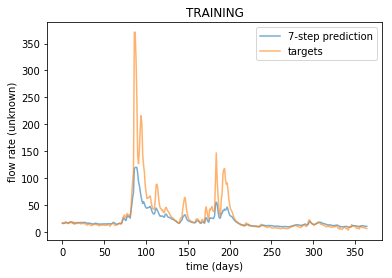

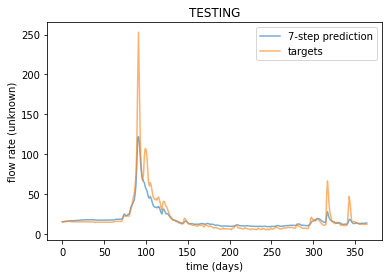

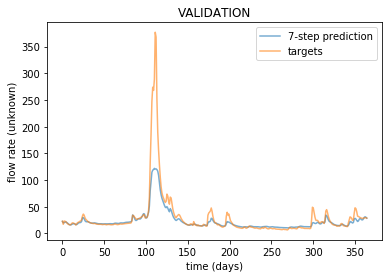

Saving set to False. Figures not saved.


In [18]:
# TRAINING THE NETWORK

# initializer of TF variables
init = tf.global_variables_initializer()

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# define unique name for log directory (one-step and multi-step are in sepparate directories)
now = datetime.now()
if par.pred_step > 1:
    logdir = "./logs/multi-step/" + now.strftime("%Y%m%d-%H%M%S") + "/"
else:
    logdir = "./logs/one-step/" + now.strftime("%Y%m%d-%H%M%S") + "/"

print(now.strftime("%Y%m%d-%H%M%S"))

for repeat in range(par.n_repeats):
#    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
    with tf.Session() as session:

        # take note of time at the start of training
        time_train_start = time.time()
        
        # initialize helping variables
        stop_training = False
        best_epoch = par.n_epochs
        
        # reset instance variables
        early_stopping.best_loss = 10000
        early_stopping.best_epoch = 0

        # Restore variables from disk if setting.continue_learning is True.
        if setting.continue_learning:
            # restoring variables will also initialize them
            saver.restore(session, './checkpoints/Multi-Step_LSTMforPredictingLabeFlow')
            print("Model restored.")
        else:
            session.run(init) # initialize variables


        # Create a SummaryWriter to output summaries and the Graph
        # in console run 'tensorboard --logdir=./logs/'
        summary_logdir = logdir + "/" + str(repeat)
        summary_writer = tf.summary.FileWriter(logdir=summary_logdir, graph=session.graph)

        for epoch in range(par.n_epochs):
            # TRAINING
            loss_val, error_val, _ = run_model(inputs.train,targets.train,par.train_batch_size,save=False,train=True)

            # TESTING
            loss_val_test, error_val_test, _ = run_model(inputs.test,targets.test,par.test_batch_size,save=False,train=False)

            # write the summaries of testing data at epoch in TensorBoard
    #        summary_writer.add_summary(summary.test, epoch)

            # increment global step for decaying learning rate at each epoch
            session.run(increment_global_step_op)

            # Printing the results at every "par.n_epochs//10" epochs
            if epoch % (par.n_epochs//10) == 0:
                print("Epoch: {}".format(epoch))
                print("TRAINING Loss: {}".format(loss_val))
                print("TRAINING Error: {}".format(error_val))
                print("TESTING Loss: {}".format(loss_val_test))
                print("TESTING Error: {}".format(error_val_test))
                # flush the summary data into TensorBoard
                # summary_writer.flush()

            # Checking the model loss_value for early stopping each "check_every" epochs
            # save the trained net and variables for later use if the test loss_val is better than the last saved one
            best_loss, best_epoch, stop_training = early_stopping(loss_val_test,epoch,par.stop_epochs,par.check_every)

            # Stop the training process
            if stop_training:
                print("The training process stopped prematurely at epoch {}.".format(epoch))
                break
                
        # take note of time at the end of training
        time_train_end = time.time()
        
        # print training time per epoch
        time_train = time_train_end - time_train_start
        print("The training took {}.".format(format_duration(time_train)))
        print("Average {} per epoch".format(format_duration(time_train/epoch)))


    # Restoring the model coefficients with best results
    with tf.Session() as session:

        # restore the net coefficients with the lowest loss value
        saver.restore(session, './checkpoints/Multi-Step_LSTMforPredictingLabeFlow')
        print('Restored model coefficients at epoch {} with TESTING loss val: {:.4f}'.format(best_epoch, best_loss))

        # run the trained net with best coefficients on all time-series and save the results
        loss_val, error_val, prediction_list = run_model(inputs.train,targets.train,par.train_batch_size,save=True,train=False)
        loss_val_test, error_val_test, prediction_list_test = run_model(inputs.test,targets.test,par.test_batch_size,save=True,train=False)
        loss_val_validation, error_val_validation, prediction_list_validation = run_model(inputs.val,targets.val,par.val_batch_size,save=True,train=False)
    

    # printing parameters and results to console
    results = '''Timestamp: {}
_____________________________________________
Net parameters:
{}
_____________________________________________
Results: \n
Best epoch ...................... {:4d}
TRAINING Loss ................... {:11.6f}
TRAINING Error .................. {:11.6f}
TESTING Loss .................... {:11.6f}
TESTING Error ................... {:11.6f}
VALIDATION Loss ................. {:11.6f}
VALIDATION Error ................ {:11.6f}
_____________________________________________'''.format(now.strftime("%Y%m%d-%H%M%S")
                                                       ,par
                                                       ,best_epoch
                                                       ,loss_val
                                                       ,error_val
                                                       ,loss_val_test
                                                       ,error_val_test
                                                       ,loss_val_validation
                                                       ,error_val_validation)

    print(results)


    # saving results to log file in logdir
    file = "{}log{}.txt".format(logdir,repeat)
    with open(file, mode='w') as f:
        f.write(results)

    # Shift the predictions "par.delay" time-steps to the right
    prediction_train = np.array(prediction_list)
    prediction_test = np.array(prediction_list_test)
    prediction_validation = np.array(prediction_list_validation)
    
    # invert the tanh standardization to give the data original scale
    y_train_denorm = z_score(targets.train, inverse=True, mean=inputs.mean, std=inputs.std)
    y_test_denorm = z_score(targets.test, inverse=True, mean=inputs.mean, std=inputs.std)
    y_validation_denorm = z_score(targets.val, inverse=True, mean=inputs.mean, std=inputs.std)

    def split_by_pred_step(raw_predictions):
        """
        split the predictions to pred_step separate time-series

        :param raw_predictions: the resulting prediction values from the neural net
        :return: a list of pred_step time-series of i-step predictions
        """
        prediction_list = [raw_predictions[i::par.pred_step] for i in range(par.pred_step)]

        return prediction_list

    def pad_by_delay(ts_list):
        """
        pad the time series with delay zeroes at the beginning

        :param ts_list: the list of time series that are to be padded with zeroes
        :return: list of padded time-series
        """
        
        return [np.pad(time_series,pad_width=((par.delay,0))
                                  ,mode='constant',constant_values=0)
                for time_series in ts_list] # pad with "par.delay" zeros at the start of first dimension

    # Plot the results
    def plot_results(raw_predictions, targets, selected_data, plot_range=slice(0,None)):
        """
        plot the predictions and target values to one figure

        :param raw_predictions: the resulting prediction values from the neural net
        :param targets: the actual values of the time series
        :param par.selected_data: selector of input data (1 == Elbe flow, 2 == Saugeen flow)
        :param plot_range: range of the data to be plotted
        :return: plot of predictions and target values
        """
        
        prediction_list = pad_by_delay([raw_predictions])        # pad with zeroes
        
        for prediction in prediction_list:
            plt.plot(prediction[plot_range],alpha=0.6)
        plt.plot(targets[plot_range], alpha=0.6)
        
        leg = ['{}-step prediction'.format(par.pred_step), 'targets']
        plt.legend(leg)
        if selected_data == 1:
            plt.xlabel('time (weeks)')
            plt.ylabel('flow rate (normalized)')
        elif selected_data == 2:
            plt.xlabel('time (days)')
            plt.ylabel('flow rate (unknown)')        
        plt.draw()

    f_training = plt.figure()
    plot_results(prediction_train, y_train_denorm, par.selected_data, plot_range)
    plt.title('TRAINING')

    f_testing = plt.figure()
    plot_results(prediction_test, y_test_denorm, par.selected_data, plot_range)
    plt.title('TESTING')

    f_validation = plt.figure()
    plot_results(prediction_validation, y_validation_denorm, par.selected_data, plot_range)
    plt.title('VALIDATION')
    plt.show()

    if setting.save_figures:
        # Save the figures:
        img_save_dir = "{}IMG".format(logdir)
        save_dir_path = os.path.join(os.curdir, img_save_dir)
        os.makedirs(save_dir_path, exist_ok=True)

        f_training.savefig(save_dir_path + "/training{}.pdf".format(repeat), bbox_inches='tight')
        f_testing.savefig(save_dir_path + "/testing{}.pdf".format(repeat), bbox_inches='tight')
        f_validation.savefig(save_dir_path + "/validation{}.pdf".format(repeat), bbox_inches='tight')

        print("Figures saved to: {}".format(save_dir_path))
    else:
        print("Saving set to False. Figures not saved.")

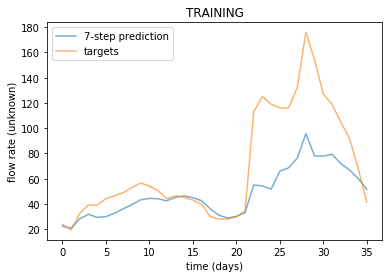

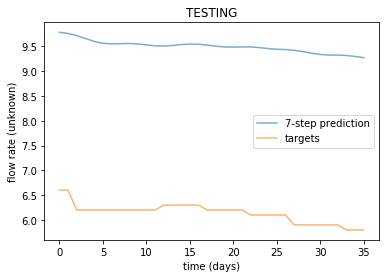

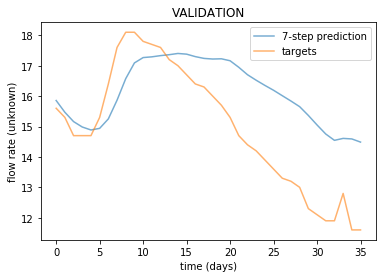

In [19]:
# plot_range = slice(int(days_in_year*1),int(days_in_year*1.1),1)
plot_range = slice(int(365*1), int(365*1.1), 1)

f_training = plt.figure()
plot_results(prediction_train, y_train_denorm, par.selected_data, plot_range)
plt.title('TRAINING')

f_testing = plt.figure()
plot_results(prediction_test, y_test_denorm, par.selected_data, plot_range)
plt.title('TESTING')

f_validation = plt.figure()
plot_results(prediction_validation, y_validation_denorm, par.selected_data, plot_range)
plt.title('VALIDATION')
plt.show()